# PRIVACY POLICY ANALYSER BOT 

### step 1 :

In [1]:
# Cell 1: Install dependencies from requirements.txt
import os


# Install
!pip install -q -r requirements.txt

print("All dependencies installed successfully!")


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
All dependencies installed successfully!


In [2]:
#!pip install -q gradio

In [3]:
# Cell 1: Install dependencies (Updated)
#!pip install langchain langchain-community langchain-openai langchain-text-splitters langgraph pydantic pypdf python-dotenv tiktoken faiss-cpu langsmith tavily-python gradio

In [4]:
# Cell 1: Install compatible LangChain version (v0.1.20)
#!pip install --force-reinstall langchain==0.1.20 langchain-community==0.0.38 langchain-core==0.1.52 langchain-openai==0.1.6 langgraph pydantic pypdf python-dotenv tiktoken faiss-cpu langsmith tavily-python gradio --force-reinstall

In [5]:
#pip install langchain.text_splitters

In [6]:
#pip install ipywidgets

In [9]:
# Cell 2: Imports & Setup
import os
import sys
import operator
import uuid
import json
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from dotenv import load_dotenv

# Robust Text Splitter Import
try:
    from langchain_text_splitters import RecursiveCharacterTextSplitter
except ImportError:
    from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END

# --- ADDED FOR STATE/MEMORY ---
from langgraph.checkpoint.memory import MemorySaver
# ------------------------------

from langchain_core.pydantic_v1 import BaseModel, Field
from pypdf import PdfReader
from langsmith import Client
from langchain.callbacks.tracers import LangChainTracer
load_dotenv()

# Setup API Keys
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "YOUR_OPENAI_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", "YOUR_TAVILY_KEY")

print("New Libraries Imported (With MemorySaver).")

New Libraries Imported (With MemorySaver).


In [10]:
# Cell 3: Setup LangSmith Tracing
def setup_tracing():
    """Setup LangSmith tracing for the entire project"""
    # Set up tracing environment
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
    os.environ["LANGCHAIN_PROJECT"] = "Privacy-Policy-Analyzer-Capstone"
    
    if os.getenv("LANGCHAIN_API_KEY"):
        try:
            client = Client()
            tracer = LangChainTracer()
            print("LangSmith tracing enabled")
            print(f"Project: {os.environ['LANGCHAIN_PROJECT']}")
            return tracer, client
        except Exception as e:
            print(f"LangSmith setup failed: {e}")
            return None, None
    else:
        print("LangSmith API key not set. Tracing is disabled.")
        return None, None

tracer, langsmith_client = setup_tracing()

LangSmith tracing enabled
Project: Privacy-Policy-Analyzer-Capstone


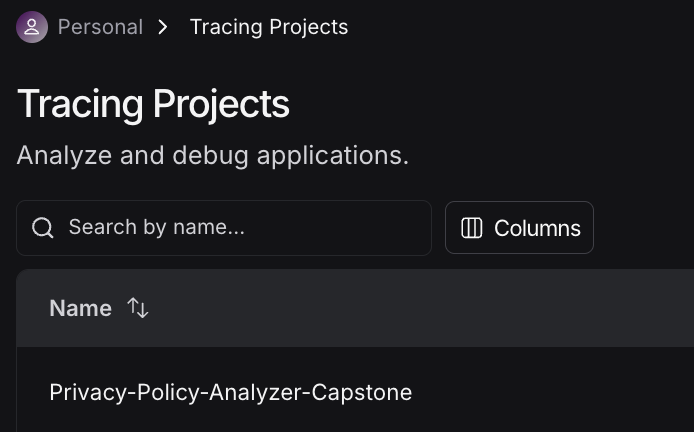

In [11]:
# Cell 4: Data Models & State (Added Summary)


# --- AGENT 1: DATA SCOUT REPORT ---
class DataCollectionReport(BaseModel):
    company_name: str = Field(..., description="Name of company.")
    privacy_email: str = Field(default="Not found", description="Contact email.")
    what_we_give: List[str] = Field(..., description="Data collected (e.g., 'Name', 'Phone').")
    how_they_get_it: List[str] = Field(..., description="Collection methods (e.g., 'Cookies').")
    why_they_want_it: List[str] = Field(..., description="Purpose (e.g., 'Targeted Ads').")
    retention_details: str = Field(default="Not specified", description="Retention period.")

# --- AGENT 2: RISK OFFICER REPORT ---
class RiskAssessmentReport(BaseModel):
    invasive_permissions: List[str] = Field(default_factory=list, description="List permissions with simple 'WHY' (e.g., 'Camera: To scan faces').")
    dark_patterns: List[str] = Field(default_factory=list, description="List tricks with simple explanation (e.g., 'Hard to Cancel').")
    vague_clauses: List[str] = Field(default_factory=list, description="Ambiguous phrases.")
    overall_risk_level: str = Field(..., description="Low, Medium, or High")

# --- AGENT 3: COMPLIANCE LAWYER REPORT ---
class ComplianceReport(BaseModel):
    gdpr_violations: List[str] = Field(default_factory=list, description="GDPR issues.")
    ccpa_violations: List[str] = Field(default_factory=list, description="CCPA issues.")
    user_rights_given_up: List[str] = Field(default_factory=list, description="Waived rights.")
    # RECOMMENDATIONS ARE HERE
    recommendations: List[str] = Field(..., description="3-5 simple, actionable steps for the user to protect themselves.")

# --- MAIN GRAPH STATE ---
class PolicyAnalyzerState(TypedDict):
    policy_text: str
    chunks: List[Any]
    relevant_sections: Dict[str, str]
    app_category: str

    # Outputs
    data_report: Optional[DataCollectionReport]
    risk_report: Optional[RiskAssessmentReport]
    compliance_report: Optional[ComplianceReport]
    reputation_data: Dict[str, Any]
    email_draft: Optional[str]

    # NEW: The Simple Summary
    english_summary: Optional[str]

    # Parallel Error Handling
    error: Annotated[List[str], operator.add]

print("State Defined with agents.")

State Defined with agents.


In [12]:
# Cell 5: Document Processor
class DocumentProcessor:
    def __init__(self):
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)

    def read_pdf(self, file_path: str) -> str:
        try:
            reader = PdfReader(file_path)
            return "".join(page.extract_text() for page in reader.pages if page.extract_text()).strip()
        except Exception as e:
            return f"Error reading PDF: {e}"

    def chunk_text(self, text: str):
        if not text: return []
        return self.text_splitter.create_documents([text])

processor = DocumentProcessor()
print(" Processor Ready.")

 Processor Ready.


In [13]:
# Cell 6 & 7: Tools & LLM
class VectorStoreManager:
    def create_vector_store(self, chunks):
        self.vector_store = FAISS.from_documents(chunks, OpenAIEmbeddings())
    def search_relevant_sections(self, query, k=3):
        return self.vector_store.similarity_search(query, k=k)

vector_manager = VectorStoreManager()
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm = llm # Alias

print("Tools Ready.")

Tools Ready.


In [14]:
# Cell 8: Define the Tavily Search Tool
#@tool
def tavily_search_tool(query: str) -> str:
    """
    Use this tool to search the internet for company reputation, privacy violation news,
    or general compliance history for the company name provided in the query.
    """
    search_tool = TavilySearchResults(k=3)
    return search_tool.invoke(query)

print(" Tavily Search Tool defined!")

 Tavily Search Tool defined!


In [15]:
# Cell 9: Agent Nodes (Improved Prompts)
def document_processing_node(state):
    print("📄 Processing...")
    text = state.get("policy_text", "") or "Privacy Policy"
    return {"chunks": processor.chunk_text(text), "policy_text": text}

def rag_retrieval_node(state):
    print("🔍 RAG...")
    if not state.get("chunks"): return {}
    try:
        vector_manager.create_vector_store(state["chunks"])
        queries = ["data collected", "permissions", "legal rights"]
        relevant = {q: "\n".join([d.page_content for d in vector_manager.search_relevant_sections(q, k=2)]) for q in queries}
        return {"relevant_sections": relevant}
    except: return {"relevant_sections": {}}

def category_classifier_node(state):
    text = state.get("policy_text", "")[:1000]
    try: cat = llm.invoke(f"Classify app: Finance, Health, Social, or General. Text: {text}").content.strip()
    except: cat = "General"
    return {"app_category": cat}

def data_scout_agent(state):
    print("🕵️ Scout...")
    text = "\n\n".join(state.get("relevant_sections", {}).values())
    try:
        extractor = structured_llm.with_structured_output(DataCollectionReport)
        report = extractor.invoke([("system", "Extract data practices."), ("user", text)])
        return {"data_report": report}
    except Exception as e: return {"error": [f"Scout: {e}"]}

# --- IMPROVED RISK OFFICER ---
def risk_officer_agent(state):
    print("👮 Risk Officer...")
    text = "\n\n".join(state.get("relevant_sections", {}).values())

    prompt = """
    You are a cynical Privacy Officer.
    1. Find 'Dark Patterns' (e.g., difficult cancellation, forced signups). Explain them in 5 words.
    2. Find invasive permissions (Mic, Camera, Location). Explain WHY they are risky in 5 words (e.g., 'Location: Tracks your daily movements').
    3. Be Simple. No Jargon.
    """

    try:
        extractor = structured_llm.with_structured_output(RiskAssessmentReport)
        report = extractor.invoke([("system", prompt), ("user", text)])
        return {"risk_report": report}
    except Exception as e: return {"error": [f"Risk: {e}"]}

# --- IMPROVED LAWYER ---
def compliance_lawyer_agent(state):
    print("⚖️ Lawyer...")
    text = "\n\n".join(state.get("relevant_sections", {}).values())

    prompt = """
    You are a helpful Privacy Lawyer.
    1. Identify rights the user gives up (e.g., Class Action Waiver).
    2. Provide 3-5 RECOMMENDATIONS. These must be actionable steps (e.g., 'Turn off Location Services', 'Request Data Deletion').
    """

    try:
        extractor = structured_llm.with_structured_output(ComplianceReport)
        report = extractor.invoke([("system", prompt), ("user", text)])
        return {"compliance_report": report}
    except Exception as e: return {"error": [f"Lawyer: {e}"]}

def reputation_agent(state):
    print("🌐 Reputation...")
    try:
        text = state.get("policy_text", "")[:500]
        name = llm.invoke(f"Extract company name: {text}").content
        res = TavilySearchResults(k=3).invoke(f"{name} privacy scandal")
        summary = llm.invoke(f"Summarize: {res}").content
        return {"reputation_data": {"summary": summary}}
    except Exception as e: return {"reputation_data": {"summary": "Search failed."}, "error": [f"Reputation: {e}"]}

def email_drafter_node(state): return {"email_draft": None}

# --- NEW: SUMMARY GENERATOR NODE ---
def summary_generation_node(state):
    print("📝 Generating TL;DR...")
    data = state.get("data_report")
    risk = state.get("risk_report")

    if not data or not risk:
        return {"english_summary": "Analysis incomplete."}

    # We ask the LLM to synthesize the findings into a simple paragraph
    prompt = f"""
    Write a 2-sentence 'Real Talk' summary of this privacy policy for a normal user.
    Risk Level: {risk.overall_risk_level}
    Company: {data.company_name}
    Bad stuff: {risk.dark_patterns}
    Permissions: {risk.invasive_permissions}

    Start with: "This app is [Risk Level] risk because..."
    """
    summary = llm.invoke(prompt).content
    return {"english_summary": summary}

print("Agents Ready (Prompts Optimized).")

Agents Ready (Prompts Optimized).


In [18]:
# Cell 10: Compile Graph
workflow = StateGraph(PolicyAnalyzerState)

workflow.add_node("process", document_processing_node)
workflow.add_node("rag", rag_retrieval_node)
workflow.add_node("classify", category_classifier_node)
workflow.add_node("data_scout", data_scout_agent)
workflow.add_node("risk_officer", risk_officer_agent)
workflow.add_node("compliance_lawyer", compliance_lawyer_agent)
workflow.add_node("reputation", reputation_agent)
workflow.add_node("drafter", email_drafter_node)
workflow.add_node("end", summary_generation_node) # Now active!

workflow.set_entry_point("process")
workflow.add_edge("process", "rag")
workflow.add_edge("rag", "classify")

# Parallel Fan-Out
workflow.add_edge("classify", "data_scout")
workflow.add_edge("classify", "risk_officer")
workflow.add_edge("classify", "compliance_lawyer")
workflow.add_edge("classify", "reputation")

# Fan-In
workflow.add_edge("data_scout", "drafter")
workflow.add_edge("risk_officer", "drafter")
workflow.add_edge("compliance_lawyer", "drafter")
workflow.add_edge("reputation", "drafter")
workflow.add_edge("drafter", "end") # Drafter leads to Summary
workflow.add_edge("end", END)

# Memory Checkpointer
memory = MemorySaver()
analyzer_workflow = workflow.compile(checkpointer=memory)

print("Multi-Agent Graph Compiled with memory")


Multi-Agent Graph Compiled with memory


In [21]:
# Cell 11: Analyzer Class (Robust Chat Fix)
import uuid

class PrivacyPolicyAnalyzer:
    def __init__(self):
        if 'analyzer_workflow' not in globals() or analyzer_workflow is None:
            raise ValueError("Graph not compiled! Please run Cell 10.")

        self.workflow = analyzer_workflow
        self.processor = processor
        self.current_analysis = {}
        print("Analyzer Ready")

    def analyze_policy(self, file_content_or_path: Optional[str] = None, policy_text: Optional[str] = None, company_name: Optional[str] = None) -> dict:
        # 1. Get Text
        if policy_text: text = policy_text
        elif file_content_or_path:
             if isinstance(file_content_or_path, str) and file_content_or_path.lower().endswith('.pdf'):
                text = self.processor.read_pdf(file_content_or_path)
             else:
                try:
                    f_path = file_content_or_path if isinstance(file_content_or_path, str) else file_content_or_path.name
                    with open(f_path, 'r', encoding='utf-8') as f: text = f.read()
                except: text = "Error reading file."
        else: text = ""

        # 2. Config (Unique Thread ID)
        thread_id = str(uuid.uuid4())
        config = {"configurable": {"thread_id": thread_id}}

        # 3. State
        initial_state = {
            "policy_text": text, "chunks": [], "relevant_sections": {}, "app_category": "General",
            "data_report": None, "risk_report": None, "compliance_report": None,
            "reputation_data": {}, "email_draft": None, "error": [],
            "english_summary": ""
        }

        try:
            final = self.workflow.invoke(initial_state, config=config)

            self.current_analysis = {
                "summary": final.get("english_summary", ""),
                "risk": final.get("risk_report", {}).dict() if final.get("risk_report") else {},
                "company": final.get("data_report", {}).company_name if final.get("data_report") else "the app"
            }

            d_rep = final.get("data_report")
            r_rep = final.get("risk_report")
            c_rep = final.get("compliance_report")
            errors = final.get("error", [])
            error_msg = "; ".join(errors) if errors else None
            to_dict = lambda x: x.dict() if x else None

            return {
                "data_report": to_dict(d_rep),
                "risk_report": to_dict(r_rep),
                "compliance_report": to_dict(c_rep),
                "reputation_data": final.get("reputation_data"),
                "email_draft": final.get("email_draft"),
                "english_summary": final.get("english_summary"),
                "error": error_msg
            }
        except Exception as e:
            return {"error": str(e)}

    def answer_user_question(self, message, history):
        """
        Robustly answers questions using RAG + Web + History.
        """
        if not self.current_analysis:
            return "⚠️ Please analyze a policy file first."

        company = self.current_analysis.get('company', 'this company')

        # --- SOURCE 1: RAG ---
        try:
            docs = vector_manager.search_relevant_sections(message, k=3)
            doc_context = "\n\n".join([d.page_content for d in docs])
        except:
            doc_context = "No specific text found in policy."

        # --- SOURCE 2: TAVILY ---
        try:
            search_query = f"{company} {message}"
            tavily = TavilySearchResults(k=2)
            web_results = tavily.invoke(search_query)
            web_context = str(web_results)
        except Exception as e:
            web_context = f"Web search failed: {str(e)}"

        # --- SOURCE 3: HISTORY (ROBUST FIX) ---
        chat_history_text = ""
        # We iterate safely to avoid "too many values to unpack"
        for item in history:
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                user_msg = item[0]
                bot_msg = item[1]
                chat_history_text += f"User: {user_msg}\nAssistant: {bot_msg}\n"

        # --- FINAL PROMPT ---
        prompt = f"""
        You are a Privacy Expert Assistant.
        User Question: "{message}"
        Company: {company}

        === SOURCE 1: OFFICIAL POLICY TEXT ===
        {doc_context}

        === SOURCE 2: WEB SEARCH RESULTS ===
        {web_context}

        === CONVERSATION HISTORY ===
        {chat_history_text}

        INSTRUCTIONS:
        1. Prioritize the Policy Text for questions about data collection, retention, or rules.
        2. Use Web Search for questions about scandals, recent news, reputation, or if the policy is silent.
        3. If sources conflict, mention both.
        4. Keep it short and helpful.
        """

        return llm.invoke(prompt).content

enhanced_analyzer = PrivacyPolicyAnalyzer()
print(" Analyzer Initialized ")

Analyzer Ready
 Analyzer Initialized 


In [23]:
# Cell 12: Gradio UI Final
import gradio as gr

def format_avengers_report(results):
    if "error" in results and results["error"]:
        return f"""
        <div style="padding: 20px; background: #fee2e2; border: 1px solid #ef4444; border-radius: 8px; color: #b91c1c;">
            <h3>⚠️ Workflow Error</h3>
            <p>{results['error']}</p>
        </div>
        """

    # Unpack
    data = results.get("data_report") or {}
    risk = results.get("risk_report") or {}
    law = results.get("compliance_report") or {}
    rep = results.get("reputation_data") or {}
    summary = results.get("english_summary") or "No summary available."

    if not data and not risk: return "⚠️ Analysis Incomplete."

    # Data Cleaning Helper
    def clean(items):
        if not items: return ["None detected."]
        return [str(i).replace('*', '') for i in items]

    # Clean the data
    company = data.get("company_name", "Unknown").replace('*', '')
    email = data.get("privacy_email", "Not found")
    lvl = risk.get("overall_risk_level", "Unknown").replace('*', '')

    # Styling Constants
    color = "#ef4444" if "High" in lvl else "#f97316" if "Medium" in lvl else "#22c55e"
    bg = color + "15"

    # Helper for Manual Bullets (Fixes White-on-White text)
    def make_list(items):
        html_list = ""
        for item in items:
            html_list += f'<div style="margin-bottom: 6px; color: #000000; font-size: 14px;">• {item}</div>'
        return html_list

    # HTML Construction
    html = f"""
    <div style="font-family: sans-serif; max-width: 900px; margin: 0 auto; background: #ffffff !important; padding: 30px; border-radius: 12px; border: 1px solid #e5e7eb; color: #000000 !important;">

        <div style="background: {bg}; border-left: 8px solid {color}; padding: 25px; border-radius: 8px; margin-bottom: 30px;">
            <div style="font-weight: bold; color: {color};">RISK: {lvl.upper()}</div>
            <h1 style="color: #000000 !important; margin: 0; font-size: 32px;">{company}</h1>
            <p style="color: #333333 !important; margin-top: 5px;">Contact: <b>{email}</b></p>
        </div>

        <div style="margin-bottom: 30px;">
            <h3 style="color: #000000 !important; border-bottom: 2px solid #e5e7eb; padding-bottom: 10px;">📝 Summary</h3>
            <p style="font-size: 16px; line-height: 1.6; color: #111111 !important;">{summary.replace('*', '')}</p>
        </div>

        <h3 style="color: #000000 !important; border-bottom: 2px solid #e5e7eb; padding-bottom: 10px;">🌍 Reputation Check</h3>
        <p style="background: #f9fafb !important; padding: 15px; border: 1px solid #e5e7eb; color: #000000 !important; border-radius: 6px;">
            {rep.get("summary", "No data available.").replace('*', '')}
        </p>

        <div style="display: flex; gap: 20px; flex-wrap: wrap; margin-top: 20px;">

            <div style="flex: 1; background: #f9fafb !important; padding: 15px; border-radius: 8px; border: 1px solid #e5e7eb;">
                <h3 style="margin-top:0; color: #000000 !important;">👻 Dark Patterns</h3>
                {make_list(clean(risk.get("dark_patterns")))}
            </div>

            <div style="flex: 1; background: #f9fafb !important; padding: 15px; border-radius: 8px; border: 1px solid #e5e7eb;">
                <h3 style="margin-top:0; color: #000000 !important;">🔓 Permissions</h3>
                {make_list(clean(risk.get("invasive_permissions")))}
            </div>

            <div style="flex: 1; background: #f9fafb !important; padding: 15px; border-radius: 8px; border: 1px solid #e5e7eb;">
                <h3 style="margin-top:0; color: #000000 !important;">⚖️ Waived Rights</h3>
                {make_list(clean(law.get("user_rights_given_up")))}
            </div>
        </div>

        <h3 style="color: #000000 !important; border-bottom: 2px solid #e5e7eb; margin-top: 30px;">📊 Data Collection</h3>
        <table style="width:100%; border-collapse: collapse; margin-top: 10px; border: 1px solid #e5e7eb;">
            <tr style="background: #f3f4f6 !important; text-align: left;">
                <th style="padding: 12px; color: #000000 !important; border-bottom: 2px solid #e5e7eb;">What</th>
                <th style="padding: 12px; color: #000000 !important; border-bottom: 2px solid #e5e7eb;">How</th>
                <th style="padding: 12px; color: #000000 !important; border-bottom: 2px solid #e5e7eb;">Why</th>
            </tr>
            <tr>
                <td style="padding: 12px; border-bottom: 1px solid #e5e7eb; vertical-align: top; color: #000000 !important;">
                    {make_list(clean(data.get("what_we_give")))}
                </td>
                <td style="padding: 12px; border-bottom: 1px solid #e5e7eb; vertical-align: top; color: #000000 !important;">
                    {make_list(clean(data.get("how_they_get_it")))}
                </td>
                <td style="padding: 12px; border-bottom: 1px solid #e5e7eb; vertical-align: top; color: #000000 !important;">
                    {make_list(clean(data.get("why_they_want_it")))}
                </td>
            </tr>
        </table>

        <h3 style="color: #000000 !important; border-bottom: 2px solid #e5e7eb; margin-top: 30px;">🛡️ How to Protect Yourself</h3>
        <div style="padding: 15px; background: #f0fdf4 !important; border: 1px solid #bbf7d0; border-radius: 8px;">
            {make_list(clean(law.get("recommendations")))}
        </div>

    </div>
    """
    return html

def run_analysis(file, text):
    path = file.name if hasattr(file, 'name') else file
    res = enhanced_analyzer.analyze_policy(file_content_or_path=path, policy_text=text)
    return format_avengers_report(res)

def run_chat(message, history):
    return enhanced_analyzer.answer_user_question(message, history)

# --- APP LAUNCH ---
with gr.Blocks() as app:
    gr.Markdown("# 🕵️‍♂️ Ultimate Privacy Analyzer + Chat")

    with gr.Row():
        with gr.Column(scale=1):
            inp_file = gr.File(label="Upload Policy PDF")
            inp_text = gr.Textbox(label="Or Paste Text", lines=5)
            btn_analyze = gr.Button("🚀 Run Full Audit", variant="primary")

        with gr.Column(scale=2):
            out_html = gr.HTML(label="Audit Report")

    gr.Markdown("## 💬 Privacy Assistant")

    # UPDATED CHAT EXAMPLES
    gr.ChatInterface(
        fn=run_chat,
        examples=[
            "What data do they sell?",
            "Can I delete my account?",
            "Is my location tracked?"
        ]
    )

    btn_analyze.click(run_analysis, inputs=[inp_file, inp_text], outputs=[out_html])

app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7896
* Running on public URL: https://837a5136ec62f06c97.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Website UI :
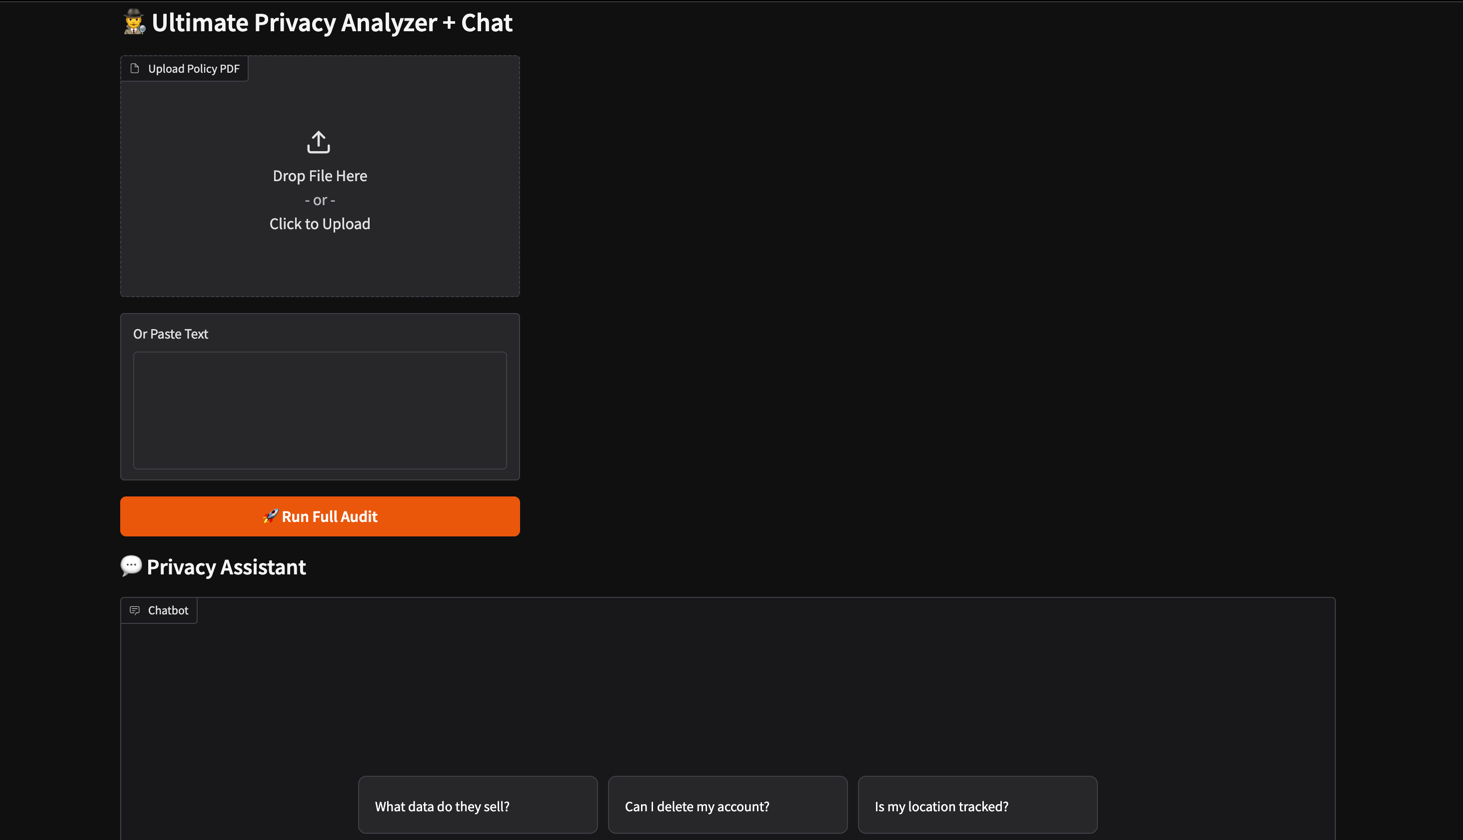

### Sample output with a google privacy policy pdf :
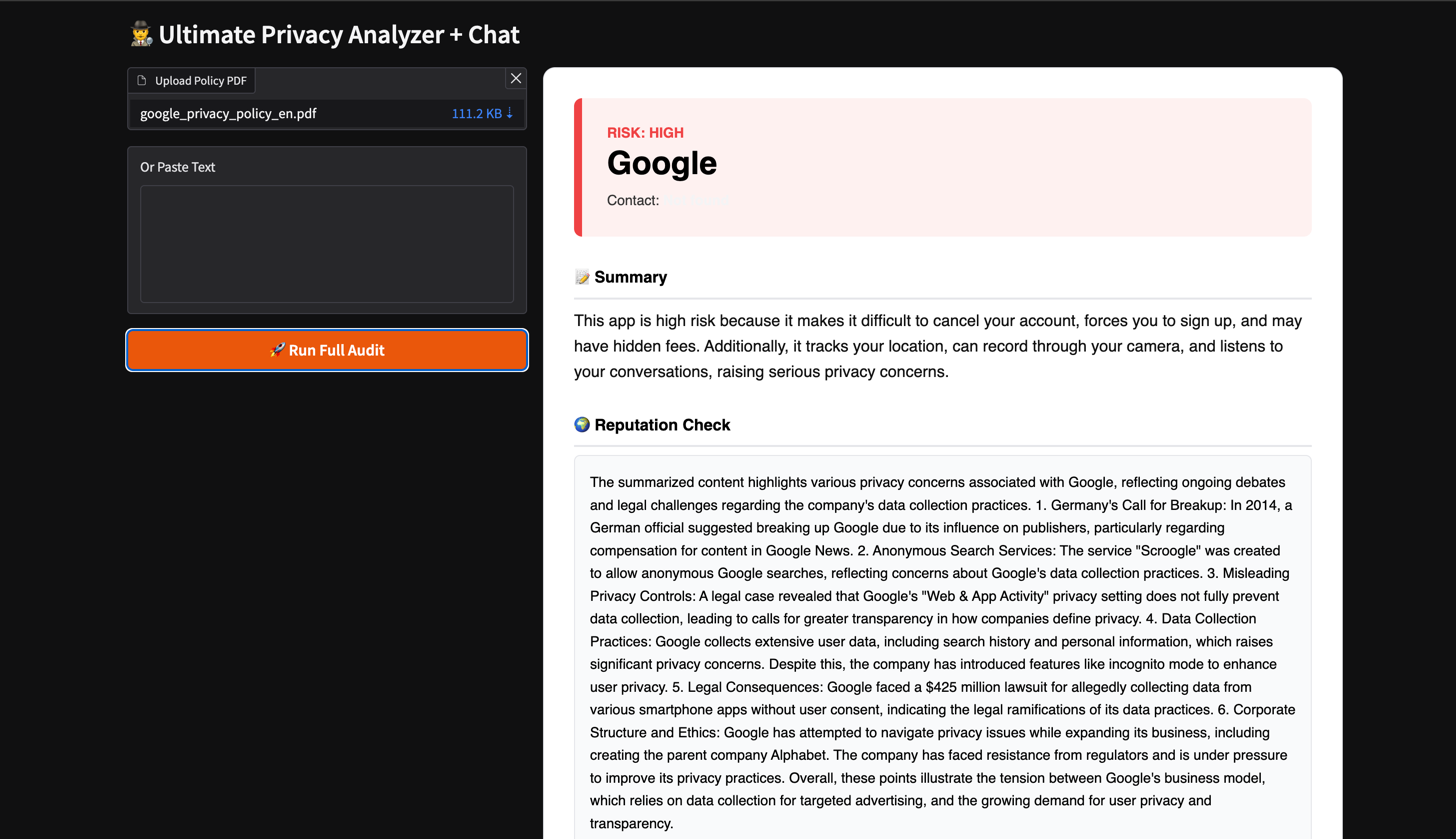
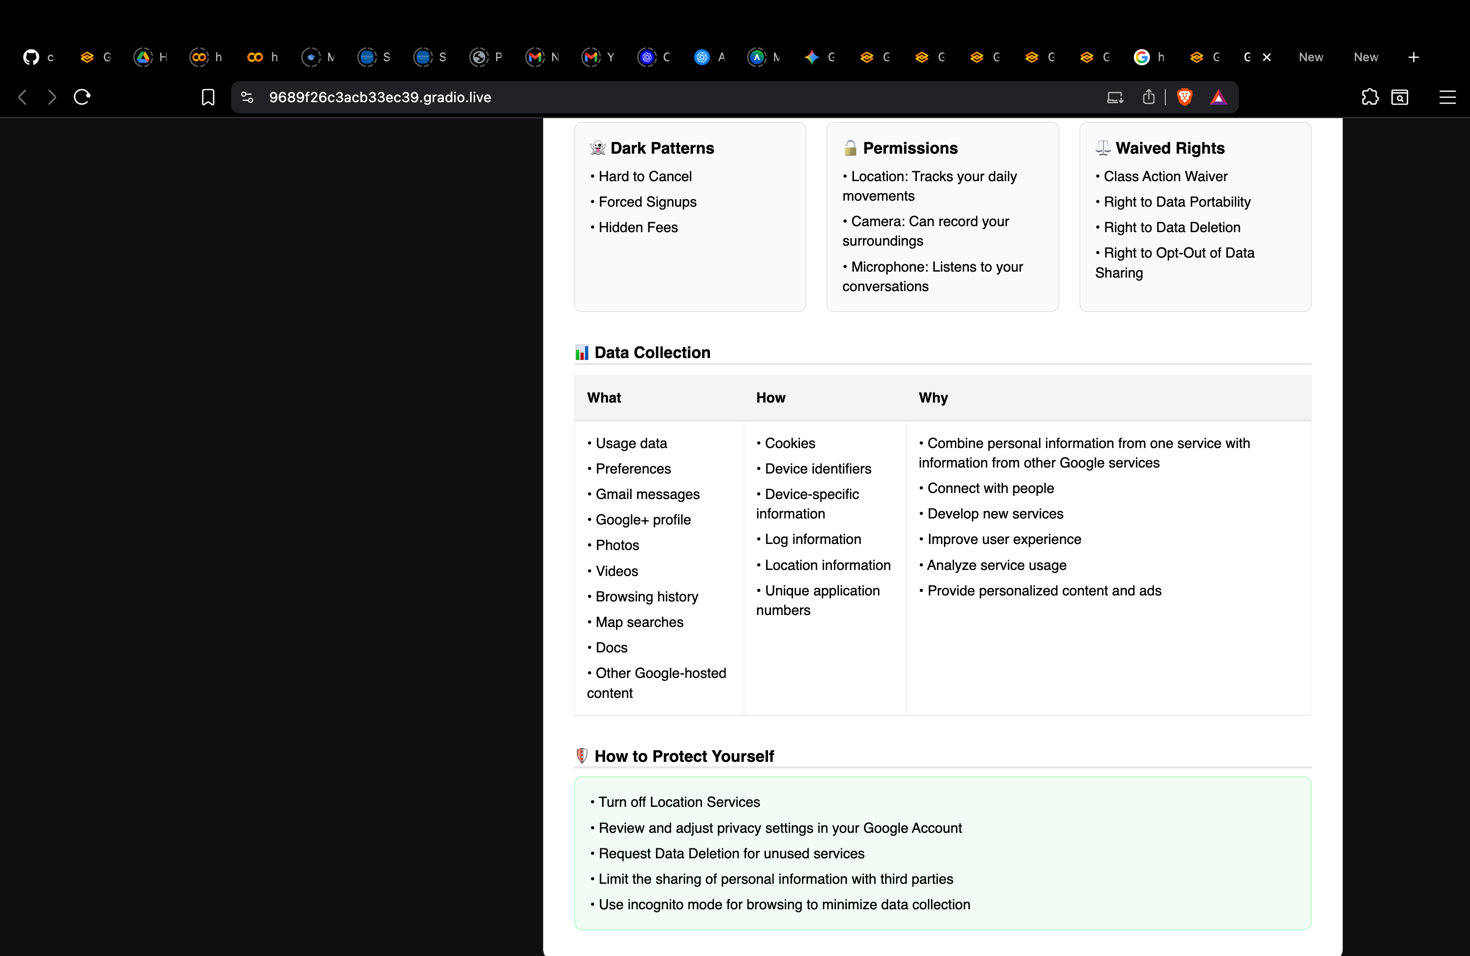
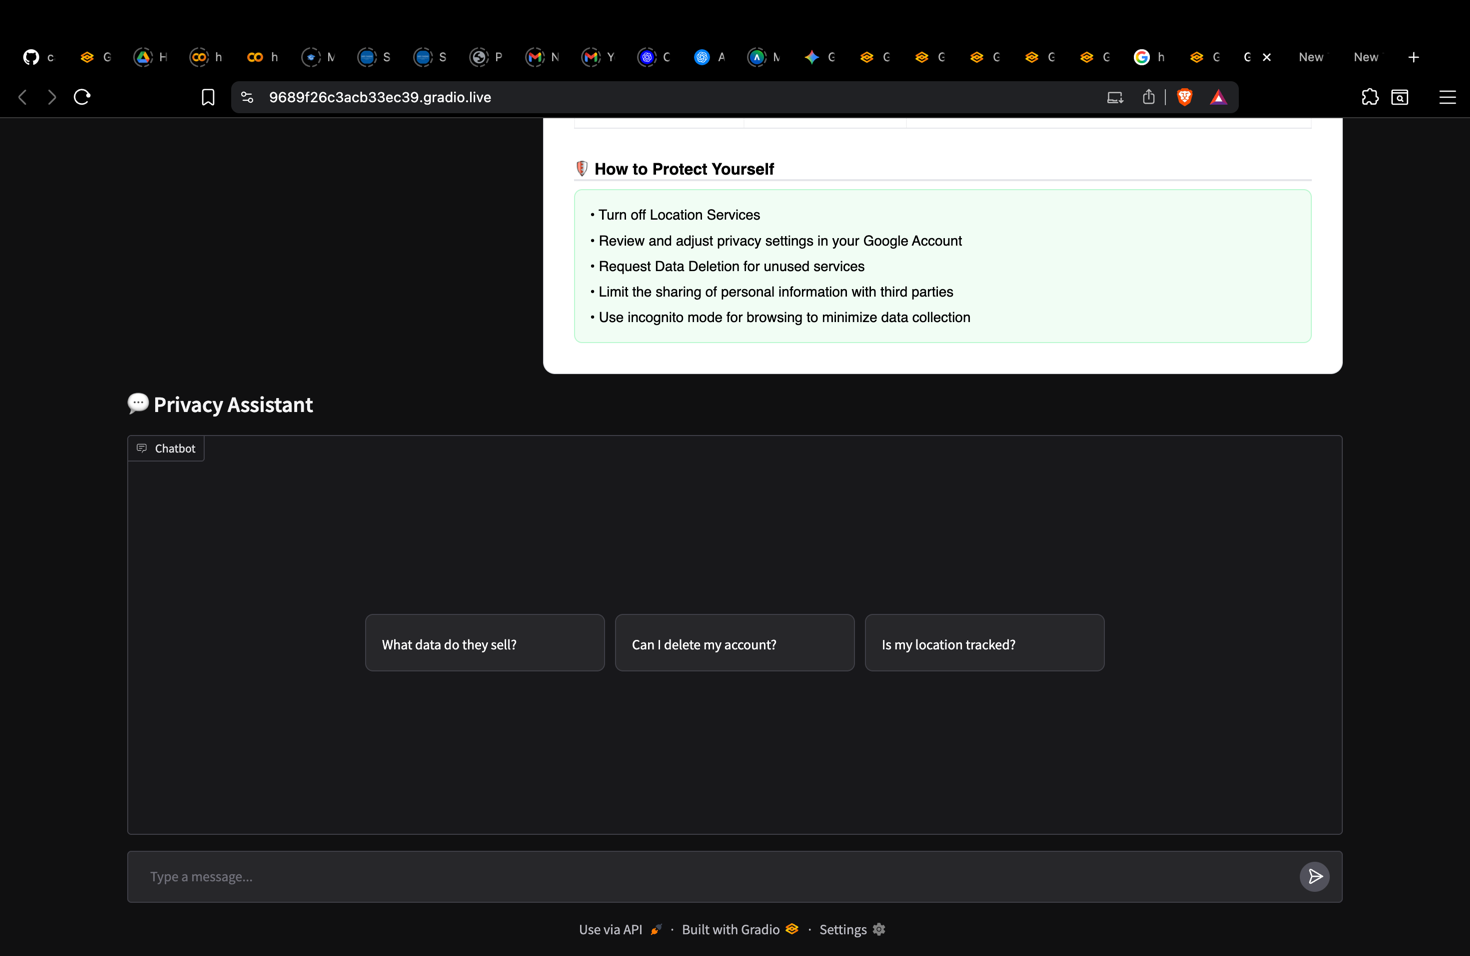